# **1. Introduction**

This notebook will go through the steps for model training and evaluation. The model used for this project is BERT.

**1.1 Set up**

In [5]:
import os
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import time
import datetime

from joblib import load
from collections import namedtuple
from typing import List, Dict, Tuple
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from joblib import dump, load

import transformers 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

In [6]:
#Get the GPU device name.
device_name = tf.test.gpu_device_name()
#The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print("GPU device not found")
    #raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


**1.2 Load dataset**

Here I chose fiction category for developing models. The size for fiction and non-fiction books are roughly balanced.

In [7]:
df = pd.read_csv('final_df.csv')
df_fiction = df[['book','genres_Fiction']]

In [8]:
df_fiction['genres_Fiction'] = df_fiction['genres_Fiction'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_fiction['genres_Fiction'].value_counts()

1    31313
0    30139
Name: genres_Fiction, dtype: int64

# **2. Model Training**

**2.1 BERT Tokenizer**

To apply pre-trained BERT model, BERT tokenizer will be used to preprocess text information. These steps will be applied:
1. tokenize text
2. add [CLS] (at the begining of sentence) and [SEP] (at the end of sentence) tokens 
3. map tokens into indexes 
4. truncate sentences, the maximum length BERT can tokenize is 512. 
5. pad sentences to maximum length
6. create attention masks.

In BERT tokenizer, encode_plus can handle all of these steps. 

In [13]:
from transformers import BertTokenizer

#Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

input_ids = []
attention_masks = []
labels = df_fiction['genres_Fiction']
max_len = 512
#For every sentence
for i in range(len(df_fiction)):
  encoded_dict = tokenizer.encode_plus(
      df_fiction['book'][i],
      add_special_tokens = True, #add '[CLS]' and '[SEP]'
      max_length = max_len, #pad and truncate 
      pad_to_max_length = True,
      return_attention_mask = True, #construct attention mask
      return_tensors = 'pt', #return pytorch tensors
  )

  #add the encoded sentence to the list
  input_ids.append(encoded_dict['input_ids'])

  #add its attention mask (simply differentiates padding from non-padding)
  attention_masks.append(encoded_dict['attention_mask'])

#convert the lists into tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
print ('Original: ', df_fiction['book'][0])
print ('-'*10)
print ('Tokenized: ', tokenizer.tokenize(df_fiction['book'][0]))
print ('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_fiction['book'][0])))

Original:  Battle Royale, Vol. 14 The beginning of the end!Shuuya, Kawada, and Noriko fight for their lives against Kiriyama, the psychotic student who decimated most of their class. While Kiriyama strives to eradicate the other kids' futures, we get an insider's view of Kiriyama's past... and what forces shaped this bright, talented young man into the unfeeling killer he is today.
The beginning of the end!Shuuya, Kawada, and Noriko fight for their lives against Kiriyama, the psychotic student who decimated most of their class. While Kiriyama strives to eradicate the other kids' futures, we get an insider's view of Kiriyama's past... and what forces shaped this bright, talented young man into the unfeeling killer he is today.
...more
Tokenized:  ['battle', 'royale', ',', 'vol', '.', '14', 'the', 'beginning', 'of', 'the', 'end', '!', 'shu', '##uy', '##a', ',', 'ka', '##wad', '##a', ',', 'and', 'nor', '##iko', 'fight', 'for', 'their', 'lives', 'against', 'ki', '##ri', '##yama', ',', 'the

In [ ]:
max_len = 0
for i in range(len(df_fiction)):
  #Tokenize the text and add '[CLS]' and '[SEP]' tokens
  synopsis = tokenizer.encode(df_fiction['book'][i], add_special_tokens = True)
  max_len = max(max_len, len(synopsis))
print ('Max sentence length: ', max_len)

Max sentence length:  4387


**2.2 Create PyTorch DataLoader**

Using pytorch dataloader to prepare training/validation dataset.

In [15]:
#combine the training inputs into a tensor dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

#divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

49,161 training samples
12,291 validation samples


In [16]:
#create dataset for training. The authors of BERT recommend a batch size of 16 or 32.
batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset), #select batch randomly
    batch_size = batch_size
)

#for validation, the order doesn't matter, so just read them sequentially
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

# 3. Train BERT

**3.1 Create Bert Classifier**

Ideally starting with the pretrained BERT and fine-tuning can acheive good performance. However, it ran out of RAM when fine-tuning the whole BERT model given the large size of BERT model. Thus, I freeze the parameters in BERT below and the last hidden layer of token [CLS] is extracted. An extra single feedforward neural network is added for fine-tuning and final classification.


In [17]:
%%time
import torch
import torch.nn as nn 
from transformers import BertModel

class BertClassifier(nn.Module):
  def __init__(self, freeze_bert = False):
    """
    @param bert: a BertModel object
    @param classifier: a torch.nn.Module classifier
    @param freeze_bert (bool): Set "False" to fine-tune BERT model
    """

    super(BertClassifier, self).__init__()
    D_in, H, D_out = 768, 50, 2

    #instantiate BERT model
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    #add one-layer feed-forward classifier
    self.classifier = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    )

    #freeze the bert model
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False
    
  def forward(self, input_ids, attention_masks):
    """
    Feed input to BERT and the classifier to compute logits.
    @param input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
    @param attention_mask (torch.Tensor): a tensor that hold attention mask information with shape (batch_size, max_length)
    @return logits (torch.Tensor): an output tensor with shape (batch_size, num_labels)
    """
    #feed input to bert
    outputs = self.bert(input_ids = input_ids,
                        attention_mask = attention_masks)
    
    #extract the last hidden state of the token '[CLS]' for classification task
    last_hidden_state_cls = outputs[0][:, 0, :]

    #feed input to classifier to compute logits
    logits = self.classifier(last_hidden_state_cls)

    return logits
    

CPU times: user 270 µs, sys: 0 ns, total: 270 µs
Wall time: 286 µs


In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs = 4):
  """
  Initialize the Bert Classifier, the optimizer and the learning rate
  """

  bert_classifier = BertClassifier(freeze_bert = True)

  #if avaiable, use GPU
  bert_classifier.to(device)

  #create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
                    lr = 5e-5,
                    eps = 1e-8)

  #total number of training steps
  total_steps = len(train_dataloader) * epochs

  #set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)
  
  return bert_classifier, optimizer, scheduler

**3.2 Model Train**

The model will be trained for 5 epochs. 

Train
*   Zero out gradients calculated in previous pass.
*   Perform a forward propogation to compute logits and loss.
*   Perform a backward propogation to compute gradients.
*   Clip the norm of the gradients to 1.0 to prevent exploding gradient.
*   Update the model's parameters.
*   Update the learning rate.


Evaluation
*   Perform a forward propogation.
*   Compute the loss and accuracy over the validation dataset.


In [21]:
import random
import time 


#specify loss function 
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value = 42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader = None, epochs = 4, evaluation = False):
  #start the training loop
  print ("Start training...\n")
  for epoch_i in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)

    #Measure the time for each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    total_loss, batch_loss, batch_counts = 0, 0, 0

    model.train()

    for step, batch in enumerate(train_dataloader):
      batch_counts += 1
      b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
      model.zero_grad()
      logits = model(b_input_ids, b_attn_mask)

      loss = loss_fn(logits, b_labels)
      batch_loss += loss.item()
      total_loss += loss.item()

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()

      #print the loss values and time elapsed for every 20 batches
      if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
        time_elapsed = time.time() - t0_batch
        print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

    avg_train_loss = total_loss / len(train_dataloader)
    print ("-"*70)

    if evaluation == True:
      val_loss, val_accuracy = evaluate(model, val_dataloader)
      time_elapsed = time.time() - t0_epoch
      print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
      print ("-"*70)
    print("\n")
  print ("Training complete!")


def evaluate(model, val_dataloader):
  model.eval()
  val_accuracy = []
  val_loss = []

  for batch in val_dataloader:
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      logits = model(b_input_ids, b_attn_mask)
    
    loss = loss_fn(logits, b_labels)
    val_loss.append(loss.item())

    preds = torch.argmax(logits, dim = 1).flatten()

    accuracy = (preds == b_labels).cpu().numpy().mean()*100
    val_accuracy.append(accuracy)

  val_loss = np.mean(val_loss)
  val_accuracy = np.mean(val_accuracy)

  return val_loss, val_accuracy


In [22]:
set_seed(12)
bert_classifier, optimizer, scheduler = initialize_model(epochs = 2)
train(bert_classifier, train_dataloader, validation_dataloader, epochs = 2, evaluation = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.663651   |     -      |     -     |  232.63  
   1    |   200   |   0.595964   |     -      |     -     |  229.85  
   1    |   300   |   0.533896   |     -      |     -     |  229.92  
   1    |   400   |   0.484266   |     -      |     -     |  229.94  
   1    |   500   |   0.460427   |     -      |     -     |  229.87  
   1    |   600   |   0.440394   |     -      |     -     |  229.92  
   1    |   700   |   0.448185   |     -      |     -     |  229.93  
   1    |   800   |   0.409847   |     -      |     -     |  229.92  
   1    |   900   |   0.394023   |     -      |     -     |  229.82  
   1    |  1000   |   0.392792   |     -      |     -     |  229.91  
   1    |  1100   |   0.403653   |     -      |     -     |  229.91  
   1    |  1200   |   0.386023   |     -      |     -     |  230.02  


# 4. Model Evaluation
In this section, model is evaluated using the validation dataset and results are plotted in ROC curve.

In [28]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
  model.eval()
  all_logits = []

  for batch in test_dataloader:
    b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

    with torch.no_grad():
      logits = model(b_input_ids, b_attn_mask)
    all_logits.append(logits)
  
  #concatenate logits from each batch
  all_logits = torch.cat(all_logits, dim = 0)

  #apply softmax to calculate probabilities 
  probs = F.softmax(all_logits, dim = 1).cpu().numpy()
  return probs

In [60]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
  preds = probs[:, 1]
  fpr, tpr, threshold = roc_curve(y_true, preds)
  roc_auc = auc(fpr, tpr)
  print (f'AUC: {roc_auc:.4f}')

  y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_true, y_pred)
  print (f'Accuracy: {accuracy*100:.2f}%')

  #plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1], 'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


In [62]:
probs = bert_predict(bert_classifier, validation_dataloader)

In [63]:
y_val = []
for i, item in enumerate(val_dataset):
  _, _, label = item 
  y_val.append(label)

AUC: 0.9118
Accuracy: 84.26%


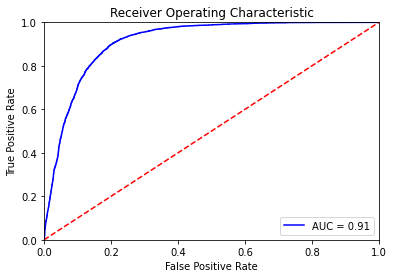

In [64]:
evaluate_roc(probs, y_val)